# Computes PLV features for later classification

This looks for drops in perionset PLV by first searching for pairs of electrodes and frequency bands that show high pre-ictal PLV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import sys
import ieeg_funcs as ief
import dgFuncs as dg
import pickle

In [57]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [2]:
# Import Clinician Szr Onset Times
sub='NA'
path_dict = ief.get_path_dict()
ieeg_root = path_dict['ieeg_root']

# Get list of files to use from clinician onset csv file
onset_csv_dir=path_dict['onset_csv']
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)
onset_df.head()

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/NA_clinician_onset_offset.csv


,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN,?,noEEGdata
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0,RHD1-2,use
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0,RHD1-2,use
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0,RHD1-2,use
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0,RHD1-2,use


In [3]:
def clin_onset_tpt(szr_name, onset_df):
    import re
    name_splt=szr_name.split('_')
    day=int(name_splt[1][1:])
    szr=int(re.findall('[0-9]+',name_splt[2])[0])
    print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

    # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
    day_ids=onset_df[onset_df['DAY']==day].index 
    szr_ids=onset_df[onset_df['SZR#']==szr].index 
    use_id=day_ids.intersection(szr_ids)
    onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
    return onset_tpt

szr_name='NA_d1_sz2.mat'
onset_tpt=clin_onset_tpt(szr_name, onset_df)

Getting clinical onset time for NA: Day 1, Szr 2


In [8]:
# Import data from one szr to estimate PLV

# Import channel names
chan_labels=ief.import_chan_labels(sub)

# Loop over usable files
#for szr_ct, szr_name in enumerate(use_szrs[0:1]): # ?? REVERT
#for szr_ct, szr_name in enumerate(use_szrs):
# Load data
# in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'.mat')
in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name)
if not os.path.isfile(in_fname):
    # Must be a subclinical seizure
    in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'_sc.mat')
szr_name_full=in_fname.split('/')[-1]
ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name_full)

onset_chan_id=12
contra_chan_id=0
print('Onset chan=%s' % chan_labels[onset_chan_id])
print('Contralat chan=%s' % chan_labels[contra_chan_id])

Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv
Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat
Onset chan=RHD1-2
Contralat chan=LHD1-2


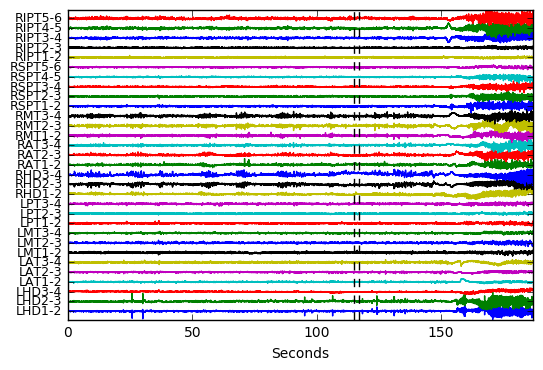

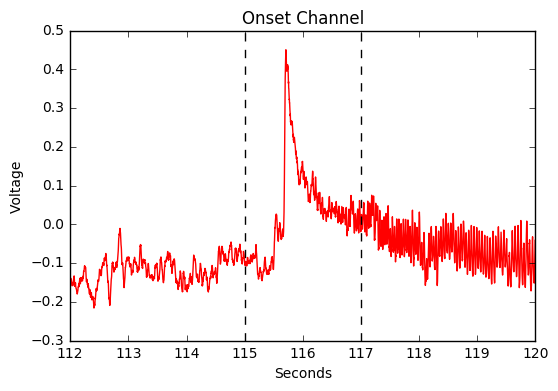

In [15]:
# Plot voltage time series and onset
plt.figure(1)
plt.clf()
[h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)
onset_upper_bnd_sec=(onset_tpt/Sf)+1
onset_lower_bnd_sec=(onset_tpt/Sf)-1
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')

# Get time points of perionset window
onset_raw_tpt_lower=dg.find_nearest(tpts_sec,onset_lower_bnd_sec)
onset_raw_tpt_upper=dg.find_nearest(tpts_sec,onset_upper_bnd_sec)
plt.figure(2)
plt.clf()
use_ids=np.arange(onset_raw_tpt_lower-Sf*3,onset_raw_tpt_upper+Sf*3)
plt.plot(tpts_sec[use_ids],ieeg[onset_chan_id,use_ids],'r')
ax=plt.gca()
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.title('Onset Channel')
plt.xlabel('Seconds')
plt.ylabel('Voltage')

In [91]:
# Compute preictal PLV between onset channel and all other channels at all frequences
n_chan=ieeg.shape[0]
# onset_chan_plv=None
wind_len=Sf # 1 second window
wind_step=Sf/10 # 0.1 second steps
first_chan=True
plv_chan_labels=list()
for a in range(n_chan):
#for a in range(10):
    if a!=onset_chan_id:
        print('Working on chan %d' % a)
        # compute PLV between this channel and onset channel
        pgram, f, pgram_sec=ief.cmpt_plvgram(ieeg[onset_chan_id,:], ieeg[a,:], Sf, wind_len, 
                                     wind_step, tpts_sec)
        if first_chan==True:
            n_freq=len(f)
            onset_chan_plv=np.zeros((n_chan,n_freq))
            med_onset_chan_plv=np.zeros((n_chan,n_freq))
            onset_pgram_tpt_lower=dg.find_nearest(pgram_sec,onset_lower_bnd_sec)
            first_chan=False
        plv_chan_labels.append(chan_labels[a])
        onset_chan_plv[a,:]=np.mean(dg.asin_trans(pgram[:,:onset_pgram_tpt_lower]),axis=1)/np.std(dg.asin_trans(pgram[:,:onset_pgram_tpt_lower]),axis=1)
        med_onset_chan_plv[a,:]=np.median(dg.asin_trans(pgram[:,:onset_pgram_tpt_lower]),axis=1)

Working on chan 0
Working on chan 1
Working on chan 2
Working on chan 3
Working on chan 4
Working on chan 5
Working on chan 6
Working on chan 7
Working on chan 8
Working on chan 9
Working on chan 10
Working on chan 11
Working on chan 13
Working on chan 14
Working on chan 15
Working on chan 16
Working on chan 17
Working on chan 18
Working on chan 19
Working on chan 20
Working on chan 21
Working on chan 22
Working on chan 23
Working on chan 24
Working on chan 25
Working on chan 26
Working on chan 27
Working on chan 28
Working on chan 29
Working on chan 30


In [96]:
srtd=np.sort(mx_plv)
print(srtd[-4:])
print(mx_plv[-4:])

[ 3.92381068  3.93091379  3.95298707  4.07425643]
[ 3.48124432  3.54661098  3.47131007  3.38983856]


Dashed line indicates top three values


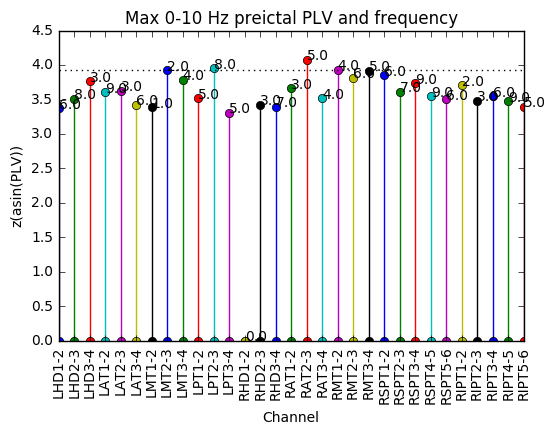

In [100]:
f_id=dg.find_nearest(f,10)
mx_plv=np.max(onset_chan_plv[:,:f_id],axis=1)
mx_plv_id=np.argmax(onset_chan_plv[:,:f_id],axis=1)
# _=plt.plot(bro,'-o')
for a in range(n_chan):
    plt.plot([a, a],[0, mx_plv[a]],'o-')
    plt.text(a,mx_plv[a],np.round(f[mx_plv_id[a]]))
_=plt.xticks(np.arange(0,n_chan),chan_labels,rotation=90)
srtd=np.sort(mx_plv)
xlim=plt.xlim()
plt.plot(xlim,(srtd[-3], srtd[-3]),'k:')
plt.xlim(xlim)
plt.ylabel('z(asin(PLV))')
plt.xlabel('Channel')
_=plt.title('Max 0-10 Hz preictal PLV and frequency')
print('Dashed line indicates top three values')

Good mean PLV chan/freqs for RHD1-2, 4-5 Hz:
* RAT2-3 @ 5 Hz
* LPT2-3 @ 8 Hz
* LMT2-3 @ 2 Hz

(1.0, 250.0)

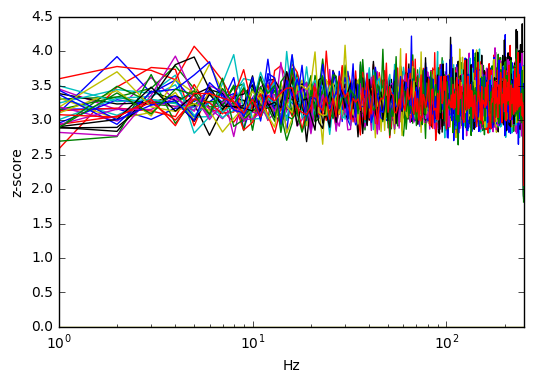

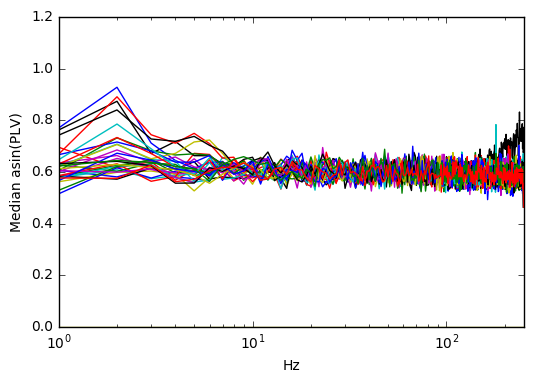

In [93]:
plt.figure(3)
plt.clf()
_=plt.plot(f,onset_chan_plv.T)
plt.xscale('log')
plt.ylabel('z-score')
plt.xlabel('Hz')
plt.xlim(f[0], f[-1])
# _=plt.plot(f,mn_plv[0,:].T,'r-')
# _=plt.plot(f,mn_plv[1,:].T,'b-')

plt.figure(4)
plt.clf()
_=plt.plot(f,med_onset_chan_plv.T)
plt.xscale('log')
plt.ylabel('Median asin(PLV)')
plt.xlabel('Hz')
plt.xlim(f[0], f[-1])

In [67]:
# Compute preictal coherence between onset channel and all other channels at all frequences
n_chan=ieeg.shape[0]
# onset_chan_plv=None
wind_len=Sf # 1 second window
wind_step=Sf/10 # 0.1 second steps
first_chan=True
plv_chan_labels=list()
n_tapers=8
for a in range(n_chan):
    if a!=onset_chan_id:
        print('Working on chan %d' % a)
        #compute coherence between this channel and onset channel
        pgram, f, pgram_sec=ief.mt_cohgram(ieeg[onset_chan_id,:], ieeg[a,:], Sf, wind_len, wind_step, n_tapers, tpts_sec)
        if first_chan==True:
            n_freq=len(f)
            onset_chan_coh=np.zeros((n_chan,n_freq))
            med_onset_chan_coh=np.zeros((n_chan,n_freq))
            onset_pgram_tpt_lower=dg.find_nearest(pgram_sec,onset_lower_bnd_sec)
            first_chan=False
        plv_chan_labels.append(chan_labels[a])
        onset_chan_coh[a,:]=np.mean(dg.asin_trans(pgram[:,:onset_pgram_tpt_lower]),axis=1)/np.std(dg.asin_trans(pgram[:,:onset_pgram_tpt_lower]),axis=1)
        med_onset_chan_coh[a,:]=np.median(dg.asin_trans(pgram[:,:onset_pgram_tpt_lower]),axis=1)

Working on chan 0


/Users/davidgroppe/anaconda/lib/python3.5/site-packages/mtspec/multitaper.py:781: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.empty(shape, dtype=self.float, order=self.order)


Working on chan 1
Working on chan 2
Working on chan 3
Working on chan 4
Working on chan 5
Working on chan 6
Working on chan 7
Working on chan 8
Working on chan 9
Working on chan 10
Working on chan 11
Working on chan 13
Working on chan 14
Working on chan 15
Working on chan 16
Working on chan 17
Working on chan 18
Working on chan 19
Working on chan 20
Working on chan 21
Working on chan 22
Working on chan 23
Working on chan 24
Working on chan 25
Working on chan 26
Working on chan 27
Working on chan 28
Working on chan 29
Working on chan 30


Dashed line indicates top three values


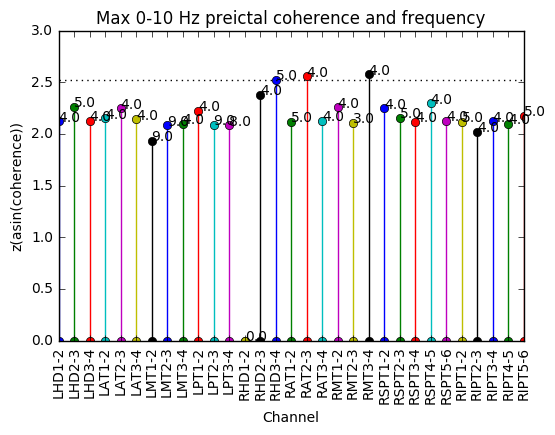

In [101]:
f_id=dg.find_nearest(f,10)
mx_coh=np.max(onset_chan_coh[:,:f_id],axis=1)
mx_coh_id=np.argmax(onset_chan_coh[:,:f_id],axis=1)
# _=plt.plot(bro,'-o')
for a in range(n_chan):
    plt.plot([a, a],[0, mx_coh[a]],'o-')
    plt.text(a,mx_coh[a],np.round(f[mx_coh_id[a]]))
_=plt.xticks(np.arange(0,n_chan),chan_labels,rotation=90)
srtd=np.sort(mx_coh)
xlim=plt.xlim()
plt.plot(xlim,(srtd[-3], srtd[-3]),'k:')
plt.xlim(xlim)
plt.ylabel('z(asin(coherence))')
plt.xlabel('Channel')
_=plt.title('Max 0-10 Hz preictal coherence and frequency')
print('Dashed line indicates top three values')

Good mean coherence chan/freqs for RHD1-2, 4-5 Hz:
* RHD3-4
* RAT2-3
* RMT3-4

(1.0040160417556763, 250.0)

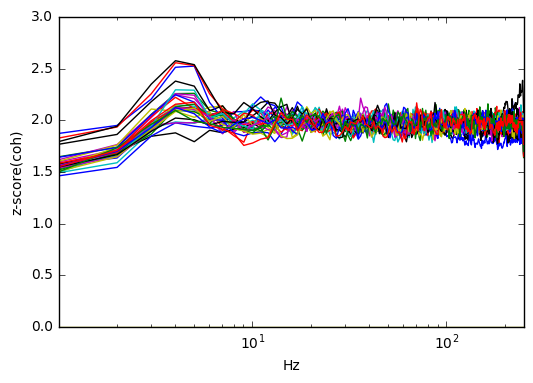

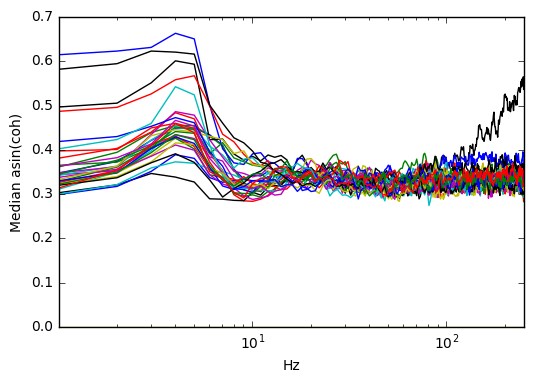

In [68]:
plt.figure(4)
plt.clf()
_=plt.plot(f,onset_chan_coh.T)
plt.xscale('log')
plt.ylabel('z-score(coh)')
plt.xlabel('Hz')
plt.xlim(f[0], f[-1])
# _=plt.plot(f,mn_plv[0,:].T,'r-')
# _=plt.plot(f,mn_plv[1,:].T,'b-')

# Find the chans with the highest coh below 10 Hz
mx_coh=

plt.figure(5)
plt.clf()
_=plt.plot(f,med_onset_chan_coh.T)
plt.xscale('log')
plt.ylabel('Median asin(coh)')
plt.xlabel('Hz')
plt.xlim(f[0], f[-1])